# 1) Movement detection

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


import glob 

import statistics

from statistics import StatisticsError

In [2]:
#To make things easier to run on this document, I renamed the directories.

files_movement = list(glob.glob("movement_test_data/*.csv"))
files_movement.sort()



The files are numbered from 1 to 5. We assume they represent 5 consecutive minutes' worth of data.

In [3]:
# Keeping the last file as a test dataset

test_file_movement = files_movement[-1]
files_movement.pop(-1)

df_movement = pd.DataFrame()

for file in files_movement:
    df_open = pd.read_csv(file, header=None)
    df_movement = pd.concat([df_movement, df_open], axis=0)
    del df_open
    
df_movement = df_movement.reset_index(drop=True)



Renaming the variable to 'obs'

In [4]:
df_movement.columns = ['obs']

Each second is made up of 250 observations

In [5]:
obs_per_sec = round(df_movement.shape[0]/(4*4*60))


In [6]:
# Calculating the basic metrics

print(df_movement.describe())

                 obs
count  239975.000000
mean       51.449868
std        14.734650
min         0.000000
25%        47.000000
50%        53.000000
75%        59.000000
max        77.000000


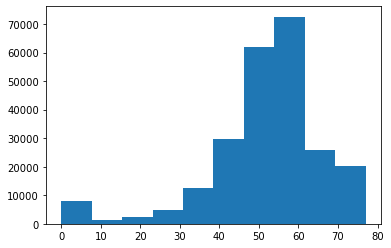

In [7]:
plt.hist(df_movement.obs);

The vast majority of values are clustered between 50 and 60

In [8]:
mean = df_movement.obs.mean()
print("Mean: {}".format(mean))

median = df_movement.obs.median()
print("Median: {}".format(median))

Mean: 51.449867694551514
Median: 53.0


###### Visualising the dataset at two cases to see if there are any unique patterns.

###### I did this visual inspection for a few more slices in Spyder, which I didn't add here. Only showing two. 

###### First we look at a slice where there is movement

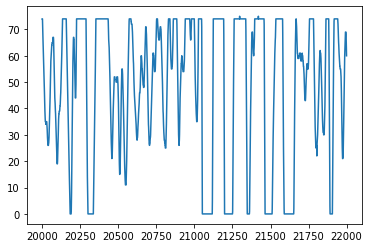

In [9]:
plt.plot(df_movement.iloc[20000:22000])

In [10]:
####### Now we look at one where there is no movement

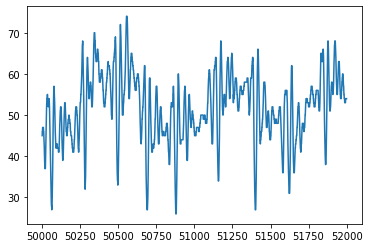

In [11]:
plt.plot(df_movement.iloc[50000:52000])

###### Notes - 

1. Where there is movement, the amplitude of the observations reaches both the upper and lower extremes on a regular basis. The peaks hit 70 and the troughs go all the way to 0. 

2. In the case of movement, the amplitudes tend to 'stick' to an extreme value for a few observations, which can possibly be used as an signal for movement.

3. When not moving, the data appears more noisy (and even sinusoidal in a way). The peaks max out to 70, but the troughs usually do not reach 0. 

###### Trying to generate some features we could possibly use - The idea is to see if any of the below is a signal for movement

In [12]:
# The deviation from the global mean and the individual observation
df_movement['diff_mean'] = mean - df_movement['obs']

# The rate of change of the deviation from mean w.r.t the mean
df_movement['delta_mean'] = abs(df_movement['diff_mean'] / mean)

#Lagged mean of delta_mean for 100 milliseconds window
df_movement['delta_mean_rolling_100ms'] = df_movement['delta_mean'].rolling(window=obs_per_sec//10).mean()

#Lagged mean of delta_mean for 200 milliseconds window
df_movement['delta_mean_rolling_200ms'] = df_movement['delta_mean'].rolling(window=obs_per_sec//5).mean()

# Absolute differencing of observations by 1 value behind (to see if the time series can be made stationary)
df_movement['diff_1'] = abs(df_movement['obs'].diff(1))

# Lagged mean of diff_1 for 10 observations
df_movement['diff_1_rolling_mean_abs'] = df_movement['diff_1'].rolling(window=10).mean()

# Absolute differencing of the previous value by 1
df_movement['diff_2'] = abs(df_movement['diff_1_rolling_mean_abs'].diff())

###### After much experimentation, I found out that values for 'delta_mean_rolling_200ms' begin to spike when movement begins and go down when movement stops.

###### The spike happens with a lag of 200 milliseconds (50 observations), since this is a rolling statistic. 

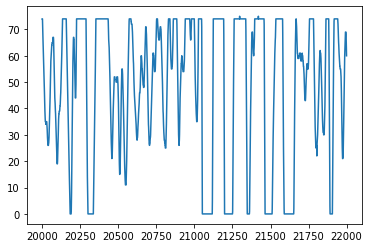

In [13]:
plt.plot(df_movement.iloc[20000:22000].obs)


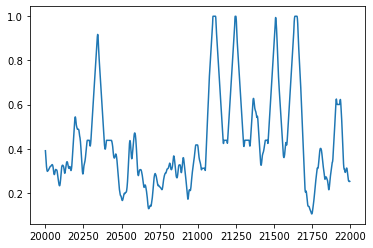

In [14]:
plt.plot(df_movement.iloc[20000:22000].delta_mean_rolling_200ms)

###### After looking at the data at many intervals, I set 'delta_mean_rolling_200ms' > 0.2 as the threshold for classifying an observation as belonging to movement.

Here, I construct a filter which assigns 1 for movement and 0 otherwise over a window of 200 milliseconds (50 observations)

In [15]:
def movement_detection_filter(df_movement, threshold=0.2):


    df_movement['movement'] = 0

    for index, row in df_movement.iterrows():

        df_movement.loc[index-49:index+1, 'movement'] = np.where(
                
                (df_movement.iloc[index]['delta_mean_rolling_200ms'] > threshold) & (
                    ~np.isnan(df_movement.iloc[index]['delta_mean_rolling_200ms']))
                , 1, 0)

    
    df_movement.loc[(np.isnan(df_movement['delta_mean_rolling_200ms'])), 'delta_mean_rolling_200ms'] = 0
    
    return df_movement



In [16]:
df_movement = movement_detection_filter(df_movement, threshold=0.2)

In [17]:
# Now using this filter on test data

In [18]:
df_movement_test = pd.read_csv(test_file_movement, header=None, names=['obs'])


In [19]:
df_movement_test['diff_mean'] = mean - df_movement_test['obs']

df_movement_test['delta_mean'] = abs(df_movement_test['diff_mean'] / mean)

df_movement_test['delta_mean_rolling_100ms'] = df_movement_test['delta_mean'].rolling(window=obs_per_sec//10).mean()

df_movement_test['delta_mean_rolling_200ms'] = df_movement_test['delta_mean'].rolling(window=obs_per_sec//5).mean()


In [20]:
df_movement_test = movement_detection_filter(df_movement_test, threshold=0.2)

Wrting True/False values when movement is detected for a particular second window (each 250 obs wide)

In [21]:
timesteps = np.arange(0, df_movement_test.shape[0], obs_per_sec)


movement_detected = pd.Series()

for sec in timesteps:
    try:
        verdict = bool(np.where(statistics.mode(df_movement_test.iloc[sec:sec+obs_per_sec]['movement']) == 1, True, False))
    except StatisticsError:
        verdict = True
        
    movement_detected[str(sec)] = verdict

We visualise this

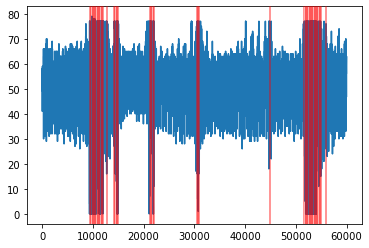

In [22]:
plt.plot(df_movement_test.obs)

for i, sec in enumerate(timesteps):
    if movement_detected[str(sec)] == True:
        plt.axvspan(sec, sec+obs_per_sec-1, alpha=0.3, color='r', zorder=20)

###### We see that the filter detects movement to a reasonable extent

# 

# 

# 2) Snoring detection

In [23]:
files_snoring = list(glob.glob("snoring_test_data/*.csv"))
files_snoring.sort()

test_file_snoring = files_snoring[-1]
files_snoring.pop(-1)

'snoring_test_data/test5.csv'

In [24]:
df_snoring = pd.DataFrame()

for file in files_snoring:
    df_open = pd.read_csv(file, header=None)
    df_snoring = pd.concat([df_snoring, df_open], axis=0)
    del df_open
    
df_snoring = df_snoring.reset_index(drop=True)

df_snoring.columns = ['obs']

In [25]:
obs_per_sec = round(df_snoring.shape[0]/(4*4*60))

Each second is made up of 250 observations

In [26]:
# Calculating the basic metrics

print(df_snoring.describe())

                 obs
count  239977.000000
mean       52.262625
std         6.865110
min         0.000000
25%        48.000000
50%        52.000000
75%        57.000000
max        77.000000


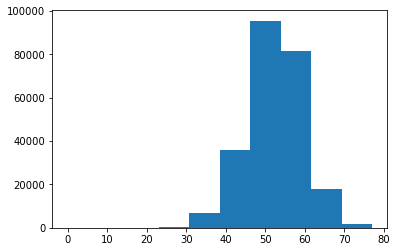

In [27]:
plt.hist(df_snoring.obs);

In [28]:
mean = df_snoring.obs.mean()
print("Mean: {}".format(mean))

median = df_snoring.obs.median()
print("Median: {}".format(median))

Mean: 52.26262516824529
Median: 52.0


###### Visualising the dataset at two cases to see if there are any unique patterns.

###### I did this visual inspection for a few more slices in Spyder, which I didn't add here. Only showing two. 

First we look at a slice where there is snoring

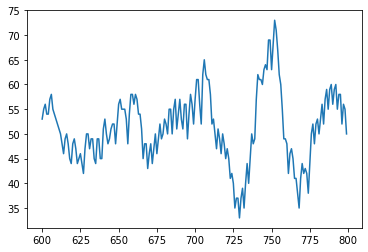

In [29]:
plt.plot(df_snoring.iloc[600:800].obs)

Now we look at where there is no snoring

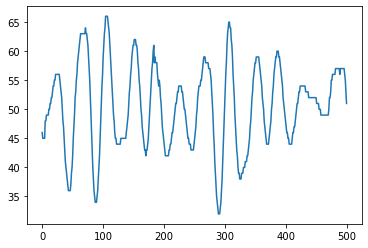

In [30]:
plt.plot(df_snoring.iloc[:500].obs)

It can be seen that snoring makes the signal more jagged and noisy. Therefore, we must find a signal that represents this noisiness. 

When there is no snoring, observations in the immediate neighbourhood seem the follow and steady upwards or downwards trend, except at peaks and troughs.

We try to see if the time-lagged values will show any interesting patterns. Autocorrelation might help.

Generating a few features based on what we see in the data - 

In [31]:
# Deviation from the mean
df_snoring['diff_mean'] = mean - df_snoring['obs']

# Rate of deviation from the mean w.r.t the mean
df_snoring['delta_mean'] = (df_snoring['diff_mean'] / mean)

#Lagged mean of delta_mean for 100 milliseconds
df_snoring['delta_mean_rolling_100ms'] = df_snoring['delta_mean'].rolling(window=obs_per_sec//10).mean()

#Lagged mean of delta_mean for 200 milliseconds
df_snoring['delta_mean_rolling_200ms'] = df_snoring['delta_mean'].rolling(window=obs_per_sec//5).mean()

# Lagged standard deviation for delta_mean for 100 milliseconds
df_snoring['delta_mean_rolling_std_100ms'] = df_snoring['delta_mean'].rolling(window=25).std()

# Lagged mean for observations for 10 observations
df_snoring['roll_mean_obs_10'] = df_snoring['obs'].rolling(window=10).mean()



# Differencing of observations going back 1
df_snoring['diff_1'] = df_snoring['obs'].diff(1)

# Lagged standard deviation for observation with window of 2 observations
df_snoring['rolling_std_2'] = df_snoring['obs'].rolling(window=2).std()

# Lagged mean for rolling_std_2 with window of 10 observations
df_snoring['rolling_std_2_rolling_mean_10'] = df_snoring['rolling_std_2'].rolling(window=10).mean()

# Differencing of observations going back 5
df_snoring['diff_5_abs'] = abs(df_snoring['obs'].diff(5))

# Centering diff_5_abs around the mean
df_snoring['diff_5_abs_centred'] = abs(df_snoring['diff_5_abs'] - df_snoring['diff_5_abs'].mean())

# Lagged sum of diff_5_abs with a window of 10 observations
df_snoring['diff_5_abs_rolling_mean'] = df_snoring['diff_5_abs'].rolling(window=10).sum()

# Lagged autocorrelation of observations with a window of 10
df_snoring['autocorr_10'] = df_snoring['obs'].rolling(window=10).apply(lambda x: x.autocorr(), raw=False)

# Lagged autocorrelation of observations with a window of 5
df_snoring['autocorr_5'] = df_snoring['obs'].rolling(window=5).apply(lambda x: x.autocorr(), raw=False)

# Dividing autocorr_5 by diff_5_abs
df_snoring['autocorr_5_plus_by_diff_5_abs'] = df_snoring['autocorr_5'] / df_snoring['diff_5_abs']

# Lagged mean of diff_mean for 100 milliseconds
df_snoring['diff_mean_rolling'] = df_snoring['diff_mean'].rolling(window=obs_per_sec//10).mean()


###### After a few trials, I found that rolling_std_2 gives a signal whenever there is snoring

###### This is the plot for rolling_std_2 where there is snoring

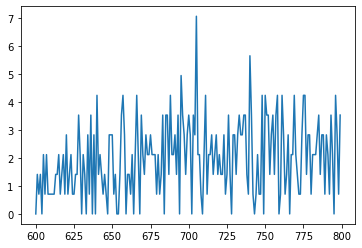

In [32]:
plt.plot(df_snoring.iloc[600:800].rolling_std_2)

###### And this is rolling_std_2 where there is no snoring

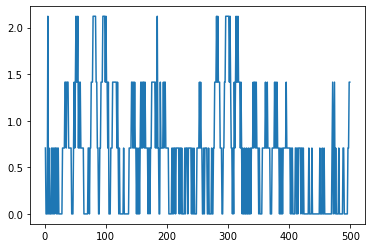

In [33]:
plt.plot(df_snoring.iloc[:500].rolling_std_2)

###### Based on this, we write a filter to detect snoring.

###### My hypothesis is that snoring occurs when the value of mean(rolling_std_2) goes above a certain threshold.

##### We define the threshold as 0.75

In [34]:
def snoring_detection_filter(df_snoring):

    df_snoring['snoring'] = 0

    for index, row in df_snoring.iterrows():
    
        df_snoring.loc[index, 'snoring'] = np.where(
                df_snoring.loc[index:index+249, 'rolling_std_2'].mean() > 0.75, 1, 0)

    return df_snoring

In [35]:
df_snoring = snoring_detection_filter(df_snoring)

Now using this filter on test data

In [36]:
df_snoring_test = pd.read_csv(test_file_snoring, header=None)


df_snoring_test = df_snoring_test.reset_index(drop=True)

df_snoring_test.columns = ['obs']

obs_per_sec = round(df_snoring_test.shape[0]/(4*4*60))



In [37]:
# Deviation from the mean
df_snoring_test['diff_mean'] = mean - df_snoring_test['obs']

# Rate of deviation from the mean w.r.t the mean
df_snoring_test['delta_mean'] = (df_snoring_test['diff_mean'] / mean)

#Lagged mean of delta_mean for 100 milliseconds
df_snoring_test['delta_mean_rolling_100ms'] = df_snoring_test['delta_mean'].rolling(window=obs_per_sec//10).mean()

#Lagged mean of delta_mean for 200 milliseconds
df_snoring_test['delta_mean_rolling_200ms'] = df_snoring_test['delta_mean'].rolling(window=obs_per_sec//5).mean()

# Lagged standard deviation for delta_mean for 100 milliseconds
df_snoring_test['delta_mean_rolling_std_100ms'] = df_snoring_test['delta_mean'].rolling(window=25).std()

# Lagged mean for observations for 10 observations
df_snoring_test['roll_mean_obs_10'] = df_snoring_test['obs'].rolling(window=10).mean()



# Differencing of observations going back 1
df_snoring_test['diff_1'] = df_snoring_test['obs'].diff(1)

# Lagged standard deviation for observation with window of 2 observations
df_snoring_test['rolling_std_2'] = df_snoring_test['obs'].rolling(window=2).std()

# Lagged mean for rolling_std_2 with window of 10 observations
df_snoring_test['rolling_std_2_rolling_mean_10'] = df_snoring_test['rolling_std_2'].rolling(window=10).mean()

# Differencing of observations going back 5
df_snoring_test['diff_5_abs'] = abs(df_snoring_test['obs'].diff(5))

# Centering diff_5_abs around the mean
df_snoring_test['diff_5_abs_centred'] = abs(df_snoring_test['diff_5_abs'] - df_snoring_test['diff_5_abs'].mean())

# Lagged sum of diff_5_abs with a window of 10 observations
df_snoring_test['diff_5_abs_rolling_mean'] = df_snoring_test['diff_5_abs'].rolling(window=10).sum()

# Lagged autocorrelation of observations with a window of 10
df_snoring_test['autocorr_10'] = df_snoring_test['obs'].rolling(window=10).apply(lambda x: x.autocorr(), raw=False)

# Lagged autocorrelation of observations with a window of 5
df_snoring_test['autocorr_5'] = df_snoring_test['obs'].rolling(window=5).apply(lambda x: x.autocorr(), raw=False)

# Dividing autocorr_5 by diff_5_abs
df_snoring_test['autocorr_5_plus_by_diff_5_abs'] = df_snoring_test['autocorr_5'] / df_snoring_test['diff_5_abs']

# Lagged mean of diff_mean for 100 milliseconds
df_snoring_test['diff_mean_rolling'] = df_snoring_test['diff_mean'].rolling(window=obs_per_sec//10).mean()


In [38]:
df_snoring_test = snoring_detection_filter(df_snoring_test)

In [39]:
# Wrting True/False values when snoring is detected for a particular second window (each 250 obs wide)

In [40]:
obs_per_step = 10

timesteps = np.arange(600, 800, obs_per_step)


snoring_detected = pd.Series()

for sec in timesteps:
    try:
        verdict = bool(np.where(statistics.mode(df_snoring_test.iloc[sec:sec+obs_per_step]['snoring']) == 1, True, False))
    except StatisticsError:
        verdict = True
        
    snoring_detected[str(sec)] = verdict

In [41]:
snoring_detected

600    True
610    True
620    True
630    True
640    True
650    True
660    True
670    True
680    True
690    True
700    True
710    True
720    True
730    True
740    True
750    True
760    True
770    True
780    True
790    True
dtype: bool

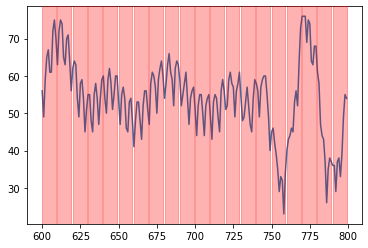

In [42]:
plt.plot(df_snoring_test.iloc[600:800].obs)

for i, sec in enumerate(timesteps):
    if snoring_detected[str(sec)] == True:
        plt.axvspan(sec, sec+obs_per_step-1, alpha=0.3, color='r', zorder=20)

# 

I'm sure there are more elegant and proper signal processing methods to solve this problem. 


For the snoring problem, we see that the frequence of the signal increases when there is snoring, at the expense of amplitude. 

1. For this reason, I also tried to perform Fourier transformation to convert the signal from time domain to frequency domain. I haven't been able to make it work yet with the time constraints. 

Some of the other things that I tried on these two problems - 

2. Time series decomposition
3. Autocorrelation measurements
4. Filling a polynomial line to detect trend (for certain features)

5. I also read a bit about Kalman filters but couldn't find the time to try to implement them here. 